# Final Project STAT 259: Single Cell Sequencing Analysis

## Introduction

In this project we build a deep learning model capable of classifying mouse cells to the appropriate organ they came from.  

The technical term for the kind of data used here is single cell transcriptome data, which basically provides the counts of RNA sequences of a very large universe of genes found in the cell. Cells coming from different organs usually have different functions, thus the number of RNA sequences transcribed will tend to be different for different organs. 

Practically speaking, the data used consists of one cell per row, and a large number of features representing the counts mentioned, with each column identified by the related gene. For this small project only two organs (labels) are considerd: kidney and liver. Except for the data processing part, the work done, and the devised model are generalizable to as many labels as needed with enough computational resources. The original data has 23k+ features per cell, and the total number of cells (rows) for the chosen organs is less than 2k, 1846 to be exact. To limit the number of features, two filters were implemented. The first is to filter the rows with zero variance. The second is to keep the rows with the highest score, defined as the difference between the means of each organ divided by the total standard deviation, which is inspired by classical stats. 1000 features were kept based on this score.  

A dataset with 1.8k rows and 1k columns could in many cases be thought as an incorrectly posed problem for traditional statistic, or even classical ML models. Many would think a high performance would not be possible, much less with a highly sophisticated model. However, this task is not only approachable by deep learning techniques when applied correctly; the accuracy obtained is above 94% out-of-sample. ROC AUC is 99%.  

The model has two distinct parts that then are seamlessly put together to work as one deep learning neural network. There are a number of best practices to avoid overfitting. Arguably the most important one here was that an autoencoder was first fitted using features only, which greatly reduces the risk of data leakage and overfitting. The autoencoder consists of an encoder and a decoder. The encoder outputs a low dimensional representation of each data point (32 dimensions in this project). The decoder then takes this embedding and tries to recover the original features. Thus the autoencoder is trained using the features as input and the same features as the target. The autoencoder archictecture considers dropout layers in between the fully connected layers in order to avoid memorization of the training data. Fully connected layers also use L1 regularization, which helps with overfitting as well. The encoder has 132k+ parameters, thus given our small sample the trained values will be fixed for the classifier down the line.  

After training the autoencoder, only the encoder part is recovered with trained parameters. The organ classifier is built on top of the encoder, both using Tensorflow. Two classifier architectures were tried, one called small that consists of the encoder + dropout + fully connected layer (output), and another called larger that has one additional hidden layer (with dropout) in between the encoder and the output layer. Both models do exceptionally well, with the small model usually doing better, but depending on the partition of data.  

Hopefully this work shows that sophisticated models like the one presented here, which leverage autoencoders and deep neural networks, can showcase the potential of machine learning in real world applications. The techniques and concepts can be perfectly applied in the field of biology, where the access to gene related data is abundant.

## Data Preprocessing

In [2]:
from genetools import dataloader
from genetools import ml

In [4]:
dp = dataloader.DataPreprocessing(
    organs = ["Kidney", "Liver"],
    y_label = "organ",
    input_path_format = "data/{organ}-counts.csv",
    output_path = f"processed_data/data.csv",
    bool_filter_zero_variance = True,
    bool_filter_mean_diff = True,
    bool_take_log = True,
    bool_save = True,
    num_genes = 1000,
)

In [5]:
data = dp.run()
data.shape

Loading data
Filtering features with zero variance
Filtering features based on difference of group means


(1846, 1001)

The details of the pre-processing are in the python scripts. At a high level the steps followed are:
- Filter features with zero variance.
- Filter features based on score defined as difference between mean (grouped by organ) divided by total standard deviation. The highest 1000 values are chosen.
- Take logarithm. This helps keep the range of feature values similar.

The number of columns of data is 1001, 1000 features and 1 label column.

## Data split

In [7]:
m = ml.Models(
    data=data,
    autoencoder_path="models/autoencoder_best.hdf5",
    encoder_path="models/encoder_best.hdf5",
    classifier_path_format="models/nn_{size}_best.hdf5",
    projection_plot_path="figures/projection.jpg",
    cv_path="tables/cv_results.csv",
    test_performance_path="tables/test_performance.csv",
    roc_path_format="figures/roc_{size}.jpg",
    confusion_matrix_path_format="figures/confusion_matrix_{size}.jpg",
    max_epochs=500,
    verbose=1,
)

In [8]:
# Shape validation for x
m.x.shape, m.x_train.shape, m.x_test.shape

((1846, 1000), (1476, 1000), (370, 1000))

In [9]:
# Shape validation for y
m.y.shape, m.y_train.shape, m.y_test.shape

((1846, 2), (1476, 2), (370, 2))

The object m, is an instance of the class Models, which keeps as attribute the data and various path in order to easily save and retrieve the models and results. It has all the functionality for training and assessing the models.

## Autoencoder

In [10]:
m.run_encoder()


Autoencoder architecture:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               128128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None

The autoencoder is a rather large model. Notice the symmetry between the encoder (first 5 layers if the input is counted) and the decoder (last 4 layers). The final output here is the encoder extracted from the trained autoencoder.

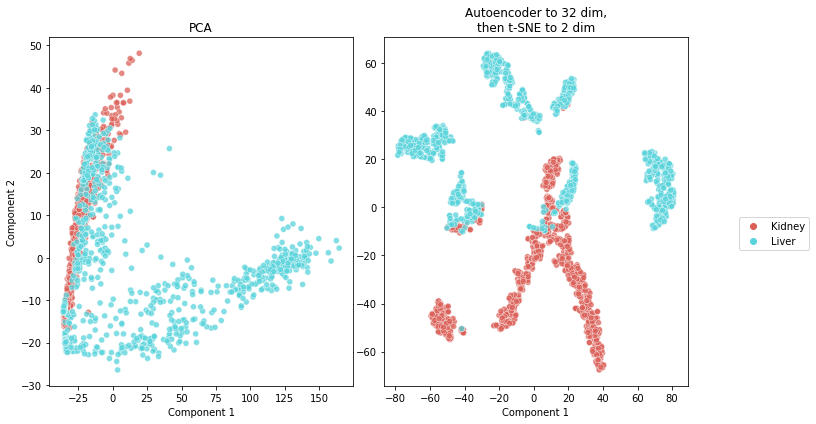

In [11]:
m.plot_encoder_2d_and_compare()

The encoder is conceptually doing a similar task as the one PCA would perform. It reduces the dimensions of the data. However, we notice the encoder (together with t-SNE for the last projection into 2D) does a much better job at finding meaningful latent variables than PCA, as clearly shown in the figure above. The task of predicting the organ seems relatively easy for a classifier that uses a useful projection. The information used should be in fact richer than what we can visualize, since the embedding has 32 dimensions, and thus some information almost surely was lost when projecting to 2 dimensions.

## Classifier

In [13]:
m.load_encoder()
m.run_classifier()


Small classifier architecture:
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               128128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)            

,accuracy,precision,recall,f1,roc_auc,categorical_crossentropy
small,0.929,0.929,0.930,0.929,0.987,0.172
larger,0.946,0.946,0.945,0.946,0.991,0.153



Cross-validation results saved at tables/cv_results.csv


As mentioned in the introduction, both the small and larger models are built on top of the encoder. The small model has an output layer right away and the larger model has a hidden layer in between the encoder and the output layer. Both use dropout right before added layers.  

Note that the cross-validated accuracy of both model is very high, with ~93% for the small model and ~95% for the larger. Precision, recall, and F1 score are all high and similar. ROC AUC is extremely high and close to 99% for both.


Test set performance:


,accuracy,precision,recall,f1,roc_auc
small,0.943,0.943,0.944,0.943,0.990
larger,0.908,0.908,0.909,0.908,0.982



Confusion Matrix Small


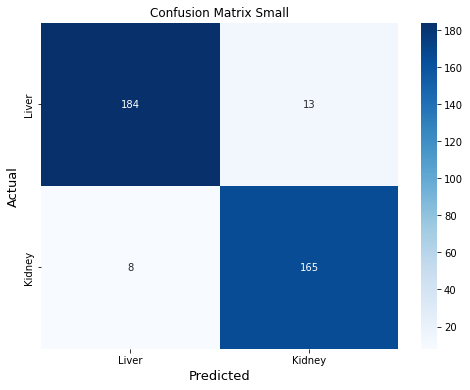


Confusion Matrix Larger


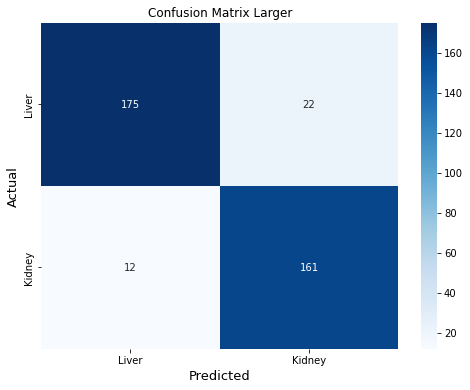


ROC curve Small


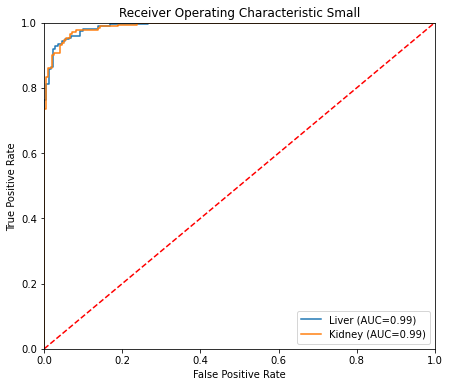


ROC curve Larger


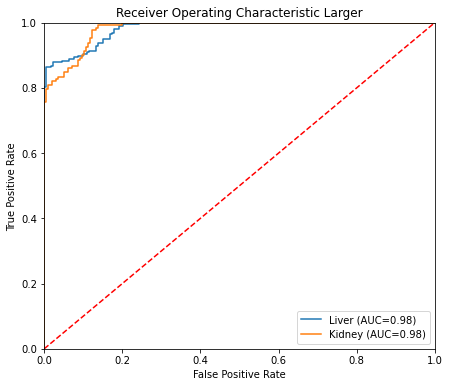

In [14]:
m.run_assessment()

This last cell shows test set results. The confusion matrix shows the predictions are well balanced. Of 370 cells in the test set, only 21 were incorrectly classified for the small model (8 incorrectly classified as liver, and 13 incorrectly classified as kidney). Out-of-sample performance metrics for the small model are comparable to those obtained by cross-validation. ROC curves for the small model look like a data scientist dream ;)